## Pretty much just what the title says
The pipe dream here is to get edge bundling to work on a spherical map; a globe, if you will. 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd
import random
import netgraph

TODO: do with PlateCarree, plotly, Dash so you can select specific nodes to highlight

## Basic example/formatting

In [2]:
# Generate random node data
num_nodes = 12
num_edges = 15
num_groups = 4
np.random.seed(0)  # Set seed for reproducibility

scale = 160

# Create random latitude and longitude
latitudes = np.random.uniform(-1*scale/2, 1*scale/2, num_nodes)
longitudes = np.random.uniform(-1*scale, 1*scale, num_nodes)

nodes_data = {
    'name': [f'Node{i}' for i in range(num_nodes)],
    'latitude': latitudes,
    'longitude': longitudes,
}

edges_data = {
    'source': np.random.choice(nodes_data['name'], num_edges),  # Random source nodes
    'target': np.random.choice(nodes_data['name'], num_edges),  # Random target nodes
    'weight': np.random.uniform(0.5, 3, num_edges)  # Random weights between 0.5 and 3
}

nodes_df = pd.DataFrame(nodes_data)
edges_df = pd.DataFrame(edges_data)
# Remove self-loops
edges_df = edges_df[edges_df['source'] != edges_df['target']]

In [3]:
pos = dict(zip(nodes_df['name'], zip(nodes_df['latitude'], nodes_df['longitude'])))
pos

{'Node0': (7.8101606283719605, 21.774259550058332),
 'Node1': (34.43029861958712, 136.19092425365153),
 'Node2': (16.442140171463024, -137.26846137667619),
 'Node3': (7.181309279503495, -132.11862409550696),
 'Node4': (-12.215232105775243, -153.53011281909576),
 'Node5': (23.343058090664982, 106.43835057534017),
 'Node6': (-9.986046197969202, 89.01016030395215),
 'Node7': (62.68368012513275, 118.40388743898211),
 'Node8': (74.18604168016469, 153.1578695144845),
 'Node9': (-18.649356987875564, 95.73074054935154),
 'Node10': (46.676006093226334, -12.32660407906181),
 'Node11': (4.62318716046471, 89.76933641166573)}

In [4]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for idx, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# Set positions based on latitude and longitude, converting to numpy arrays
positions = {
    row['name']: np.array([row['longitude'], row['latitude']])
    for idx, row in nodes_df.iterrows()
}

# Randomly assign a group to each node
nodes_df['group'] = np.random.choice(range(num_groups), num_nodes)

# Use a colormap to assign colors to groups
cmap = cm.get_cmap('Set2')  # Use Set2 colormap for up to num_groups
node_colors = {row['name']: cmap(row['group']) for idx, row in nodes_df.iterrows()}  # Map nodes to RGBA colors

C:\Users\elija\AppData\Local\Temp\ipykernel_12384\2230788205.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2')  # Use Set2 colormap for up to num_groups


In [5]:
pos = {name: np.array([lon, lat]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}
pos

{'Node0': array([21.77425955,  7.81016063]),
 'Node1': array([136.19092425,  34.43029862]),
 'Node2': array([-137.26846138,   16.44214017]),
 'Node3': array([-132.1186241 ,    7.18130928]),
 'Node4': array([-153.53011282,  -12.21523211]),
 'Node5': array([106.43835058,  23.34305809]),
 'Node6': array([89.0101603, -9.9860462]),
 'Node7': array([118.40388744,  62.68368013]),
 'Node8': array([153.15786951,  74.18604168]),
 'Node9': array([ 95.73074055, -18.64935699]),
 'Node10': array([-12.32660408,  46.67600609]),
 'Node11': array([89.76933641,  4.62318716])}

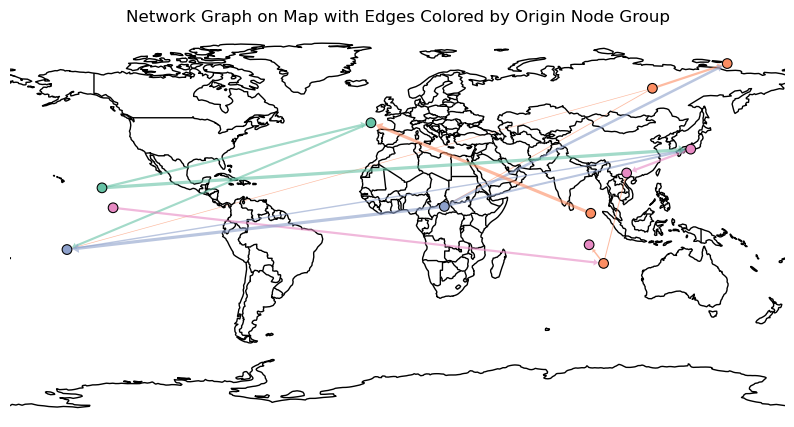

In [6]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to show the area of interest (you can adjust these values)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add features to the map (coastlines, borders, etc.)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Assuming your nodes have latitude and longitude information in `nodes_df`
# Create a custom node layout with geographic coordinates
node_layout = {name: (lon, lat) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}

edge_colors = {
    (source, target): node_colors[source]
    for source, target in zip(edges_df['source'], edges_df['target'])
}

# Now plot the network on top of the map with edges colored by the source node's group
netgraph.Graph(
    G,
    node_layout=pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight']*50 for u, v, d in G.edges(data=True)},
    node_edge_width=50,
    node_size=250,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout='curved', 
#     edge_layout_kwargs=dict(compatibility_threshold=0, k=0, total_cycles=8, total_iterations=100, step_size=.01),
    edge_color=edge_colors,  # Use the computed edge colors as a dictionary
    edge_alpha=0.6,
    prettify=True,
    ax=ax  # Plot on the same axes as the map
)

# Add title
plt.title("Network Graph on Map with Edges Colored by Origin Node Group")

# Show the plot
plt.show()

## The difference between indentical graphs at different scales

C:\Users\elija\anaconda3\Lib\site-packages\netgraph\_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


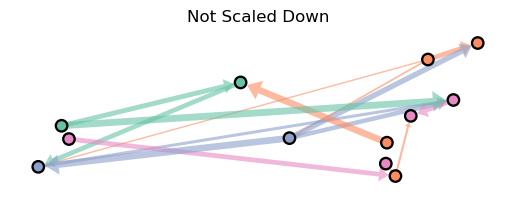

In [7]:
pos = {name: np.array([lon, lat]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}
edge_colors = {
    (source, target): node_colors[source]
    for source, target in zip(edges_df['source'], edges_df['target'])
}

netgraph.Graph(
    G,
#     node_layout='community', node_layout_kwargs=dict(node_to_community=dict(zip(nodes_df['name'], nodes_df['group']))),
    node_layout = pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight']*scale for u, v, d in G.edges(data=True)},
    node_edge_width=scale,
    node_size=3*scale,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout='bundled', 
    edge_layout_kwargs=dict(compatibility_threshold=0.00, k=0, straighten_by=0),
    edge_color=edge_colors,  # Use the computed edge colors as a dictionary
    edge_alpha=0.6,
    prettify=True,
)
plt.title('Not Scaled Down')
plt.show()

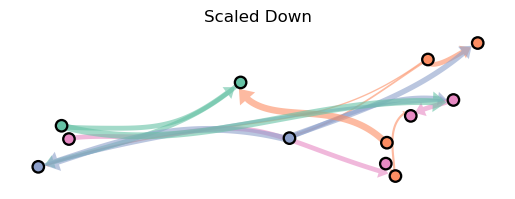

In [8]:
# base range of 1
pos = {name: np.array([lon/scale, lat/scale]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}

netgraph.Graph(
    G,
#     node_layout='community', node_layout_kwargs=dict(node_to_community=dict(zip(nodes_df['name'], nodes_df['group']))),
    node_layout = pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight'] for u, v, d in G.edges(data=True)},
    node_edge_width=1,
    node_size=3,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout='bundled', 
#     edge_layout_kwargs=dict(compatibility_threshold=0, k=1000, straighten_by=0),
    edge_color=edge_colors,  # Use the computed edge colors as a dictionary
    edge_alpha=0.6,
    prettify=True,
)
plt.title('Scaled Down')
plt.show()

## Scaling down, performing bundling, then scaling back up (and using `Cartopy`)
This doesn't look half bad, but it only works with `ccrs.PlateCarree`; using any other projections causes the graph to not appear. To get around this, we have to not use `netgraph` and instead plot the lines using `matplotlib` directly. 

In [9]:
pos = {name: np.array([lon, lat]) for name, lon, lat in zip(nodes_df['name'], nodes_df['longitude'], nodes_df['latitude'])}

scaled_pos = dict(pd.DataFrame(pos)/scale)

edges = list(G.edges)

"https://netgraph.readthedocs.io/en/latest/edge_layout.html#netgraph.get_bundled_edge_paths"
paths = netgraph.get_bundled_edge_paths(edges=edges, 
                                node_positions=scaled_pos,
#                                 compatibility_threshold=0,
#                                 straighten_by=0.1,
                                step_size=0.04)

for key, value in paths.items():
    paths[key] = value * scale

paths;

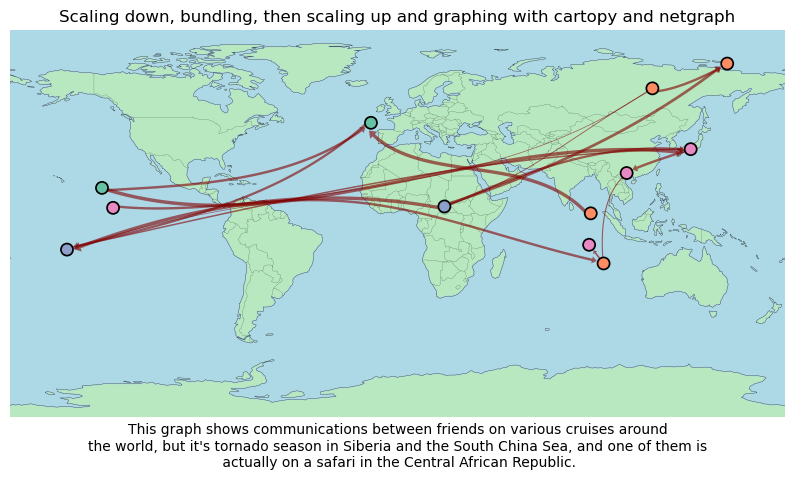

In [10]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to show the area of interest (you can adjust these values)
ax.set_global()

# Add features to the map (coastlines, borders, etc.)
"https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html"

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.1)
ax.add_feature(cartopy.feature.LAND, color='#b7e8bf')
ax.add_feature(cartopy.feature.OCEAN, color='lightblue')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.2)
# ax.stock_img()

netgraph.Graph(
    G,
    node_layout = pos,
    node_color=node_colors,
    edge_width={(u, v): d['weight']*scale/3 for u, v, d in G.edges(data=True)},
    node_edge_width=.5*scale,
    node_size=2*scale,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_layout=paths, 
    edge_color='maroon', 
    edge_alpha=0.6,
    prettify=True,
    ax=ax,
    transform=ccrs.PlateCarree()
)

plt.title('Scaling down, bundling, then scaling up and graphing with cartopy and netgraph')
plt.xlabel("This graph shows communications between friends on various cruises around\nthe world, \
but it's tornado season in Siberia and the South China Sea, and one of them is\n \
actually on a safari in the Central African Republic.", fontsize=10)
plt.show()

## Attempting to get other projections to work
And hey, they do! We lose our arrows, because we're no longer plotting with `netgraph`, but I'm still chalking that up as a win. 

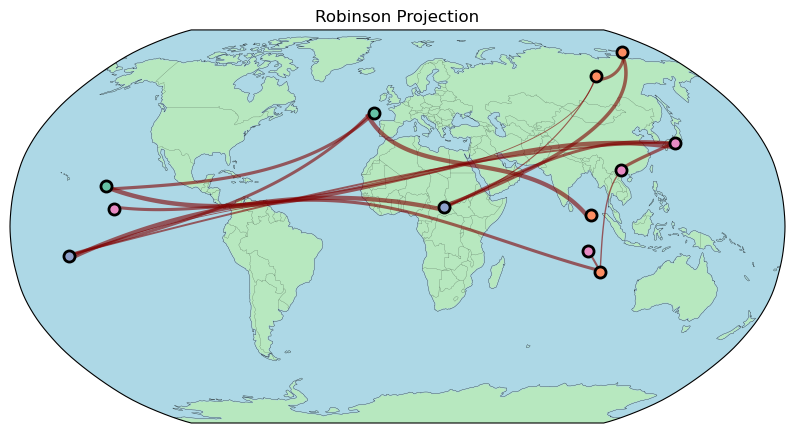

In [11]:
"https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html"
projection = ccrs.Robinson
weights = {(u, v): d['weight']*scale/3 for u, v, d in G.edges(data=True)}

# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection()})

# Set the extent to show the area of interest (you can adjust these values)
ax.set_global()

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.1)
ax.add_feature(cartopy.feature.LAND, color='#b7e8bf')
ax.add_feature(cartopy.feature.OCEAN, color='lightblue')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.2)
# ax.stock_img()

for nodes, path in paths.items():
    ax.plot(path[:, 0], path[:, 1],
            color='maroon',
            linewidth=weights[nodes]/50,
            alpha=.6,
            transform=ccrs.PlateCarree()
            )
    
    
for node, loc in pos.items():
    ax.plot(loc[0], loc[1], 
            'o', color=node_colors[node],
            markersize=8,
            markeredgecolor='black', markeredgewidth=2,
            transform=ccrs.PlateCarree())

plt.title(f'{projection.__name__} Projection')
plt.show()

## Experimenting with Folium
Folium is cranky. `step_size` has to be really small to let the interactive elements make visual sense, but as step size gets smaller, the edges bundle less. 

In [12]:
import folium
import matplotlib as mpl

In [13]:
m = folium.Map(tiles="Cartodb Positron", prefer_canvas =True,
#                min_zoom=1, max_zoom=2
              )

weights = {(u, v): d['weight']*scale/3 for u, v, d in G.edges(data=True)}
for nodes, path in paths.items():
    
    folium.PolyLine(path[:, [1, 0]], 
                    tooltip=nodes,
                    color="maroon", opacity=.6,
                    weight=weights[nodes]/50,
#                     smooth_factor=50,
                   ).add_to(m)
    
for node, loc in pos.items():
    folium.CircleMarker(
        location=[loc[1], loc[0]],
        tooltip=node,
        radius=6,
        color='black',
        fill_color=mpl.colors.rgb2hex(node_colors[node]),
        fill=True,
        fill_opacity=1,
    ).add_to(m)

m

# Real Importation Data: small example using Korea

In [14]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [15]:
credentials = service_account.Credentials.from_service_account_file('C:\\Users\\elija\\Documents\\24f-coop\\credentials.json')
project = 'net-data-viz-handbook'

# Initialize a GCS client
client = bigquery.Client(credentials=credentials, project=project)

In [16]:
# Query to get country for area plot
query = """
SELECT 
  i.source_basin, 
  g1.basin_label AS source_basin_label,
  i.target_basin, 
  g2.basin_label AS target_basin_label,
  SUM(i.importations) AS exportations
FROM 
  `net-data-viz-handbook.importation_data.sir_importations_1` AS i
JOIN 
  `net-data-viz-handbook.reference.gleam-geo-map` AS g1
ON 
  g1.basin_id = i.source_basin
JOIN 
  `net-data-viz-handbook.reference.gleam-geo-map` AS g2
ON 
  g2.basin_id = i.target_basin
WHERE g1.country_id = 115 AND g2.country_id = 115
GROUP BY 
  i.source_basin, 
  i.target_basin,
  g1.basin_label,
  g2.basin_label
"""


# Run the query
query_job = client.query(query)

# Fetch the results into a pandas DataFrame
results = query_job.result().to_dataframe()

# Display the first few rows
results.head()

C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


source_basin source_basin_label  target_basin target_basin_label  \
0          2801               Jeju          2803              Seoul   
1          2801               Jeju          2806              Pusan   
2          2801               Jeju          2808            Gwangju   
3          2801               Jeju          2800           Cheongju   
4          2800           Cheongju          2801               Jeju   

   exportations  
0         10582  
1          1907  
2          1187  
3          1645  
4          1650

In [17]:
coordinates = {
    'Cheongju': (36.6425, 127.4890),
    'Daegu': (35.8714, 128.6014),
    'Gunsan': (35.9670, 126.7367),
    'Gwangju': (35.1595, 126.8526),
    'Jeju': (33.4996, 126.5312),
    'Muan': (34.9915, 126.4782),
    'Pusan': (35.1796, 129.0756),
    'Seoul': (37.5665, 126.9780),
    'Ulsan': (35.5384, 129.3114),
    'Won-ju': (37.3422, 127.9202),
    'Yeosu': (34.7604, 127.6622)
}
df_coords = pd.DataFrame(coordinates).T.reset_index()
df_coords.columns = ['basin', 'lat', 'lon']
df_coords

basin      lat       lon
0   Cheongju  36.6425  127.4890
1      Daegu  35.8714  128.6014
2     Gunsan  35.9670  126.7367
3    Gwangju  35.1595  126.8526
4       Jeju  33.4996  126.5312
5       Muan  34.9915  126.4782
6      Pusan  35.1796  129.0756
7      Seoul  37.5665  126.9780
8      Ulsan  35.5384  129.3114
9     Won-ju  37.3422  127.9202
10     Yeosu  34.7604  127.6622

In [18]:
df_edges = results[['source_basin_label', 'target_basin_label', 'exportations']]
df_edges.sort_values('exportations', ascending=False).head()

source_basin_label target_basin_label  exportations
0                Jeju              Seoul         10582
32              Seoul               Jeju         10405
7               Pusan              Seoul          1951
6               Pusan               Jeju          1912
1                Jeju              Pusan          1907

In [19]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for idx, row in df_edges.iterrows():
    G.add_edge(row['source_basin_label'], row['target_basin_label'], weight=row['exportations'])

In [20]:
# Create a custom node layout with geographic coordinates
node_layout = {name: (lon, lat) for name, lon, lat in zip(df_coords['basin'], df_coords['lon'], df_coords['lat'])}

scaled_pos = {basin: np.array((coords[0]/180, coords[1]/180)) for basin, coords in node_layout.items()}

edges = list(G.edges)

"https://netgraph.readthedocs.io/en/latest/edge_layout.html#netgraph.get_bundled_edge_paths"
paths = netgraph.get_bundled_edge_paths(edges=edges, 
                                node_positions=scaled_pos,
#                                 compatibility_threshold=0,
                                straighten_by=0.01,
                                step_size=0.0005) # as map gets smaller, so does step size, but edges bundle less

for key, value in paths.items():
    paths[key] = value * 180

paths;

C:\Users\elija\anaconda3\Lib\site-packages\netgraph\_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


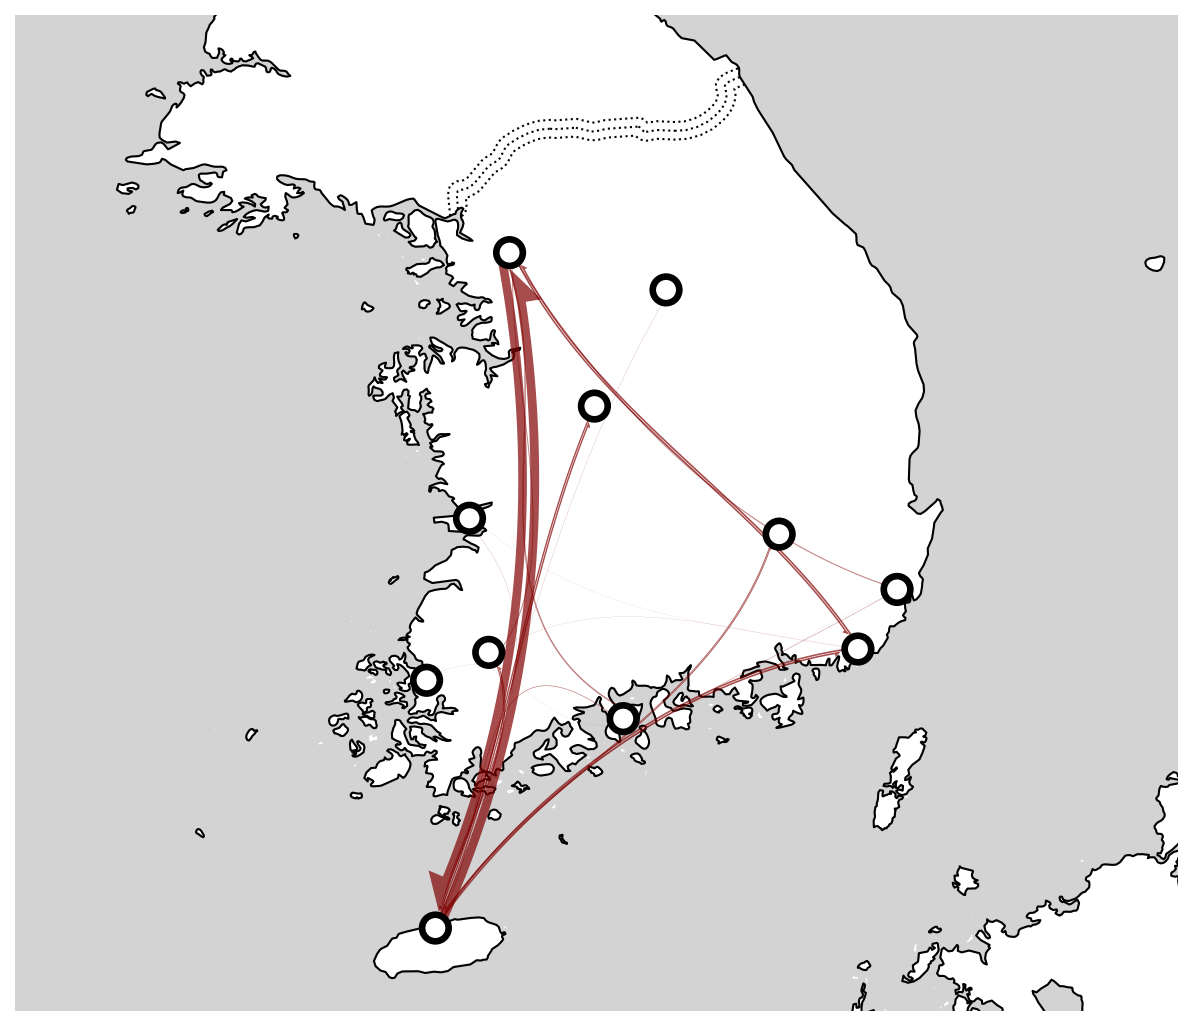

In [21]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)

# Set the extent to show the area of interest (you can adjust these values)
ax.set_extent([124, 131, 33, 39], crs=ccrs.PlateCarree())

# Add features to the map (coastlines, borders, etc.)
# gl = ax.gridlines(draw_labels=True, linestyle='-', color='gray', alpha=.3)
# gl.top_labels = False  # Disable top labels
# gl.right_labels = False  # Disable right-side labels

ax.coastlines(linewidth=1)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')

# Now plot the network on top of the map with edges colored by the source node's group
netgraph.Graph(
    G,
    node_layout=node_layout,
    edge_width={(u, v): d['weight']/1000 for u, v, d in G.edges(data=True)},
    node_edge_width=4,
    node_size=10,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_color='maroon',
    edge_layout=paths,
    edge_alpha=0.7,
    prettify=True,
    ax=ax,  # Plot on the same axes as the map
)
# Show the plot
plt.show()

In [22]:
weights = dict(zip(tuple(zip(results['source_basin_label'], results['target_basin_label'])), results['exportations']))

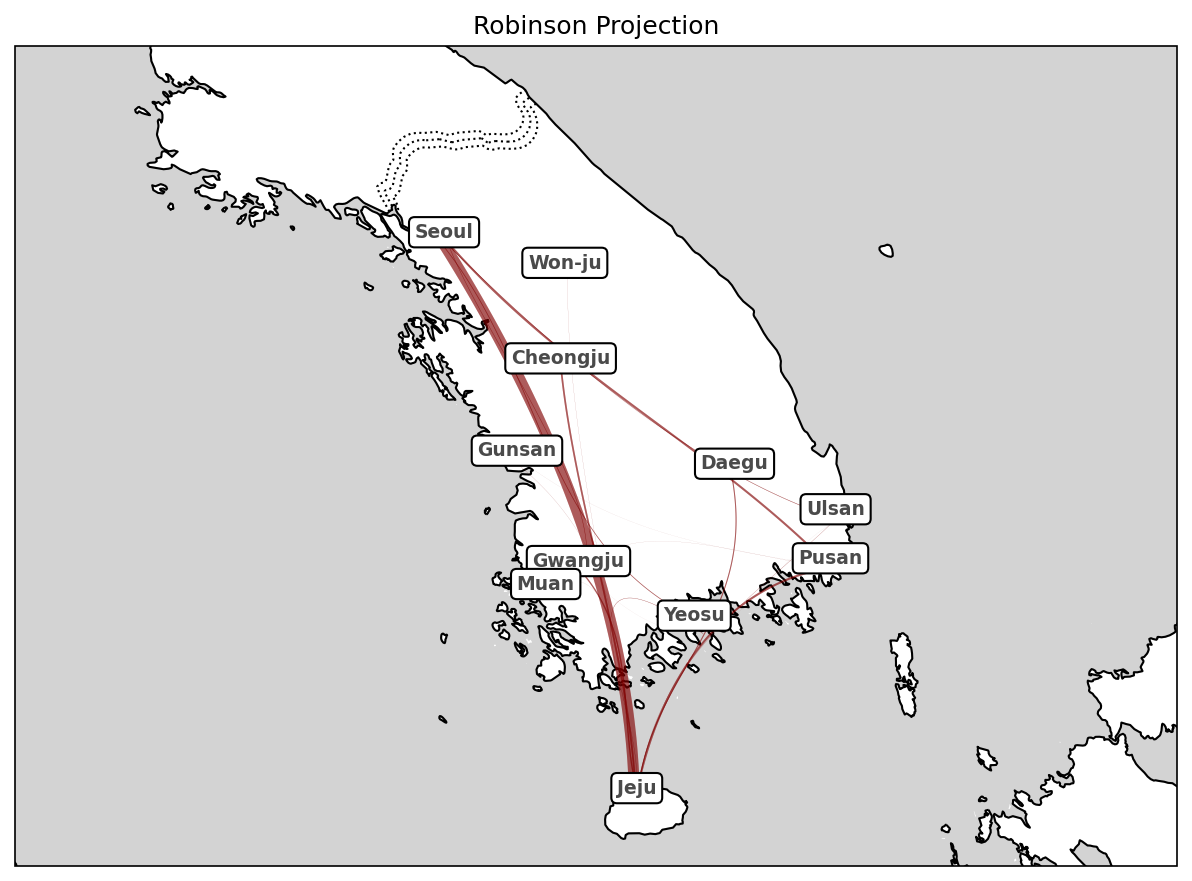

In [23]:
"https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html"
projection = ccrs.Robinson

# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection()}, dpi=150)
ax.set_extent([124, 131, 33, 39])

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1)

for nodes, path in paths.items():
    edge_width = (weights[nodes]/1000)**1/2
    ax.plot(path[:, 0], path[:, 1],
            color='maroon',
            linewidth=edge_width,
            alpha=.4,
            transform=ccrs.PlateCarree()
            )
    
    
for node, loc in node_layout.items():
    
#     # circular node
#     ax.plot(loc[0], loc[1], 
#             'o', color='white', markersize=12,
#             markeredgecolor='black', markeredgewidth=3.5,
#             transform=ccrs.PlateCarree())
    
    # Add text above the node with a box
    ax.text(loc[0], loc[1] + 0, node, 
            fontsize=9, fontweight='bold', color = '#4a4a4a',
            ha='center', va='bottom', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
            transform=ccrs.PlateCarree())

plt.title(f'{projection.__name__} Projection')
plt.show()

## Large example using US basins

In [24]:
q = """
SELECT 
  i.source_basin, 
  g1.basin_label AS source_basin_label,
  g1.latitude AS source_lat, g1.longitude AS source_lon, 
  g2.latitude AS lat, g2.longitude AS lon, 
  i.target_basin, 
  g2.basin_label AS target_basin_label,
  SUM(i.importations) AS exportations
FROM 
  `net-data-viz-handbook.importation_data.sir_importations_1` AS i
JOIN 
  `net-data-viz-handbook.reference.gleam-geo-map` AS g1
ON 
  g1.basin_id = i.source_basin
JOIN 
  `net-data-viz-handbook.reference.gleam-geo-map` AS g2
ON 
  g2.basin_id = i.target_basin
WHERE 
  g1.country_id = 218 OR g2.country_id = 218
GROUP BY 
  i.source_basin, 
  i.target_basin,
  g1.basin_label,
  g2.basin_label,
  g2.latitude, 
  g2.longitude,
  g1.latitude, 
  g1.longitude
HAVING
  SUM(i.importations) > 1000

"""

# Run the query
query_job = client.query(q)

# Fetch the results into a pandas DataFrame
results = query_job.result().to_dataframe()

# Display the first few rows
results.head()

C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


source_basin source_basin_label  source_lat  source_lon      lat       lon  \
0          2272           SanDiego     32.7336   -117.1897  37.6189 -122.3917   
1          2511           Honolulu     21.3278   -157.9222  20.8986 -156.4306   
2          2318            Kahului     20.8986   -156.4306  21.3278 -157.9222   
3          2204            Atlanta     33.6367    -84.4281  40.6397  -73.7789   
4          2303       SaltLakeCity     40.7883   -111.9778  33.9425 -118.4081   

   target_basin target_basin_label  exportations  
0          2375       SanFrancisco          2926  
1          2318            Kahului          1693  
2          2511           Honolulu          1704  
3          2518            NewYork          2923  
4          2393         LosAngeles          1520

In [25]:
q = """
WITH filtered_importations AS ( --this is the same query as above
  SELECT 
    i.source_basin, 
    g1.basin_label AS source_basin_label,
    g1.latitude AS source_lat, 
    g1.longitude AS source_lon, 
    g2.latitude AS lat, 
    g2.longitude AS lon, 
    i.target_basin, 
    g2.basin_label AS target_basin_label,
    SUM(i.importations) AS exportations
  FROM 
    `net-data-viz-handbook.importation_data.sir_importations_1` AS i
  JOIN 
    `net-data-viz-handbook.reference.gleam-geo-map` AS g1
  ON 
    g1.basin_id = i.source_basin
  JOIN 
    `net-data-viz-handbook.reference.gleam-geo-map` AS g2
  ON 
    g2.basin_id = i.target_basin
  WHERE 
    g1.country_id = 218 OR g2.country_id = 218
  GROUP BY 
    i.source_basin, 
    i.target_basin,
    g1.basin_label,
    g2.basin_label,
    g2.latitude, 
    g2.longitude,
    g1.latitude, 
    g1.longitude
  HAVING
    SUM(i.importations) > 1000
)

-- Get unique basins for node_layout
SELECT DISTINCT
  source_basin_label AS basin_label, 
  source_lon AS lon, 
  source_lat AS lat
FROM filtered_importations

UNION DISTINCT

SELECT DISTINCT
  target_basin_label AS basin_label, 
  lon AS lon, 
  lat AS lat
FROM filtered_importations

"""

# Run the query
query_job = client.query(q)

# Fetch the results into a pandas DataFrame
all_basins = query_job.result().to_dataframe()

# Create the node_layout dictionary
node_layout = dict(zip(all_basins['basin_label'], np.array(list(zip(all_basins['lon'], all_basins['lat'])))))

# Check the result
node_layout

C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


{'SanDiego': array([-117.1897,   32.7336]),
 'Honolulu': array([-157.9222,   21.3278]),
 'Kahului': array([-156.4306,   20.8986]),
 'Atlanta': array([-84.4281,  33.6367]),
 'SaltLakeCity': array([-111.9778,   40.7883]),
 'Sacramento': array([-121.5908,   38.6956]),
 'Portland(US-OR)': array([-122.5975,   45.5886]),
 'Seattle': array([-122.3094,   47.4489]),
 'Phoenix': array([-112.0117,   33.4342]),
 'Charlotte': array([-80.9431,  35.2139]),
 'TelAviv': array([34.8806, 32.0072]),
 'Minneapolis': array([-93.2217,  44.8819]),
 'Philadelphia': array([-75.2411,  39.8719]),
 'WestPalmBeach': array([-80.0956,  26.6831]),
 'Santiago': array([-70.6047,  19.4061]),
 'Tampa': array([-82.5333,  27.9756]),
 'TokyoNarita': array([140.3864,  35.7647]),
 'Detroit': array([-83.3533,  42.2125]),
 'Miami': array([-80.2906,  25.7933]),
 'London(UK)': array([-0.4614, 51.4775]),
 'Houston': array([-95.3414,  29.9844]),
 'Baltimore': array([-76.6683,  39.1753]),
 'Denver': array([-104.6731,   39.8617]),
 'S

In [26]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for idx, row in results.iterrows():
    G.add_edge(row['source_basin_label'], row['target_basin_label'], weight=row['exportations'])

In [27]:
scaled_pos = {basin: np.array((coords[0]/180, coords[1]/180)) for basin, coords in node_layout.items()}

edges = list(G.edges)

"https://netgraph.readthedocs.io/en/latest/edge_layout.html#netgraph.get_bundled_edge_paths"
paths = netgraph.get_bundled_edge_paths(edges=edges, 
                                node_positions=scaled_pos,
#                                 compatibility_threshold=0,
#                                 straighten_by=0.01,
                                step_size=0.0005) # as map gets smaller, so does step size, but edges bundle less

for key, value in paths.items():
    paths[key] = value * 180

paths;

C:\Users\elija\anaconda3\Lib\site-packages\netgraph\_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


In [28]:
def normalize_dict_values(input_dict):
    # Get the minimum and maximum values from the dictionary
    min_val = min(input_dict.values())
    max_val = max(input_dict.values())
    
    # Normalize values
    normalized_dict = {
        key: (value - min_val) / (max_val - min_val) for key, value in input_dict.items()
    }
    
    return normalized_dict

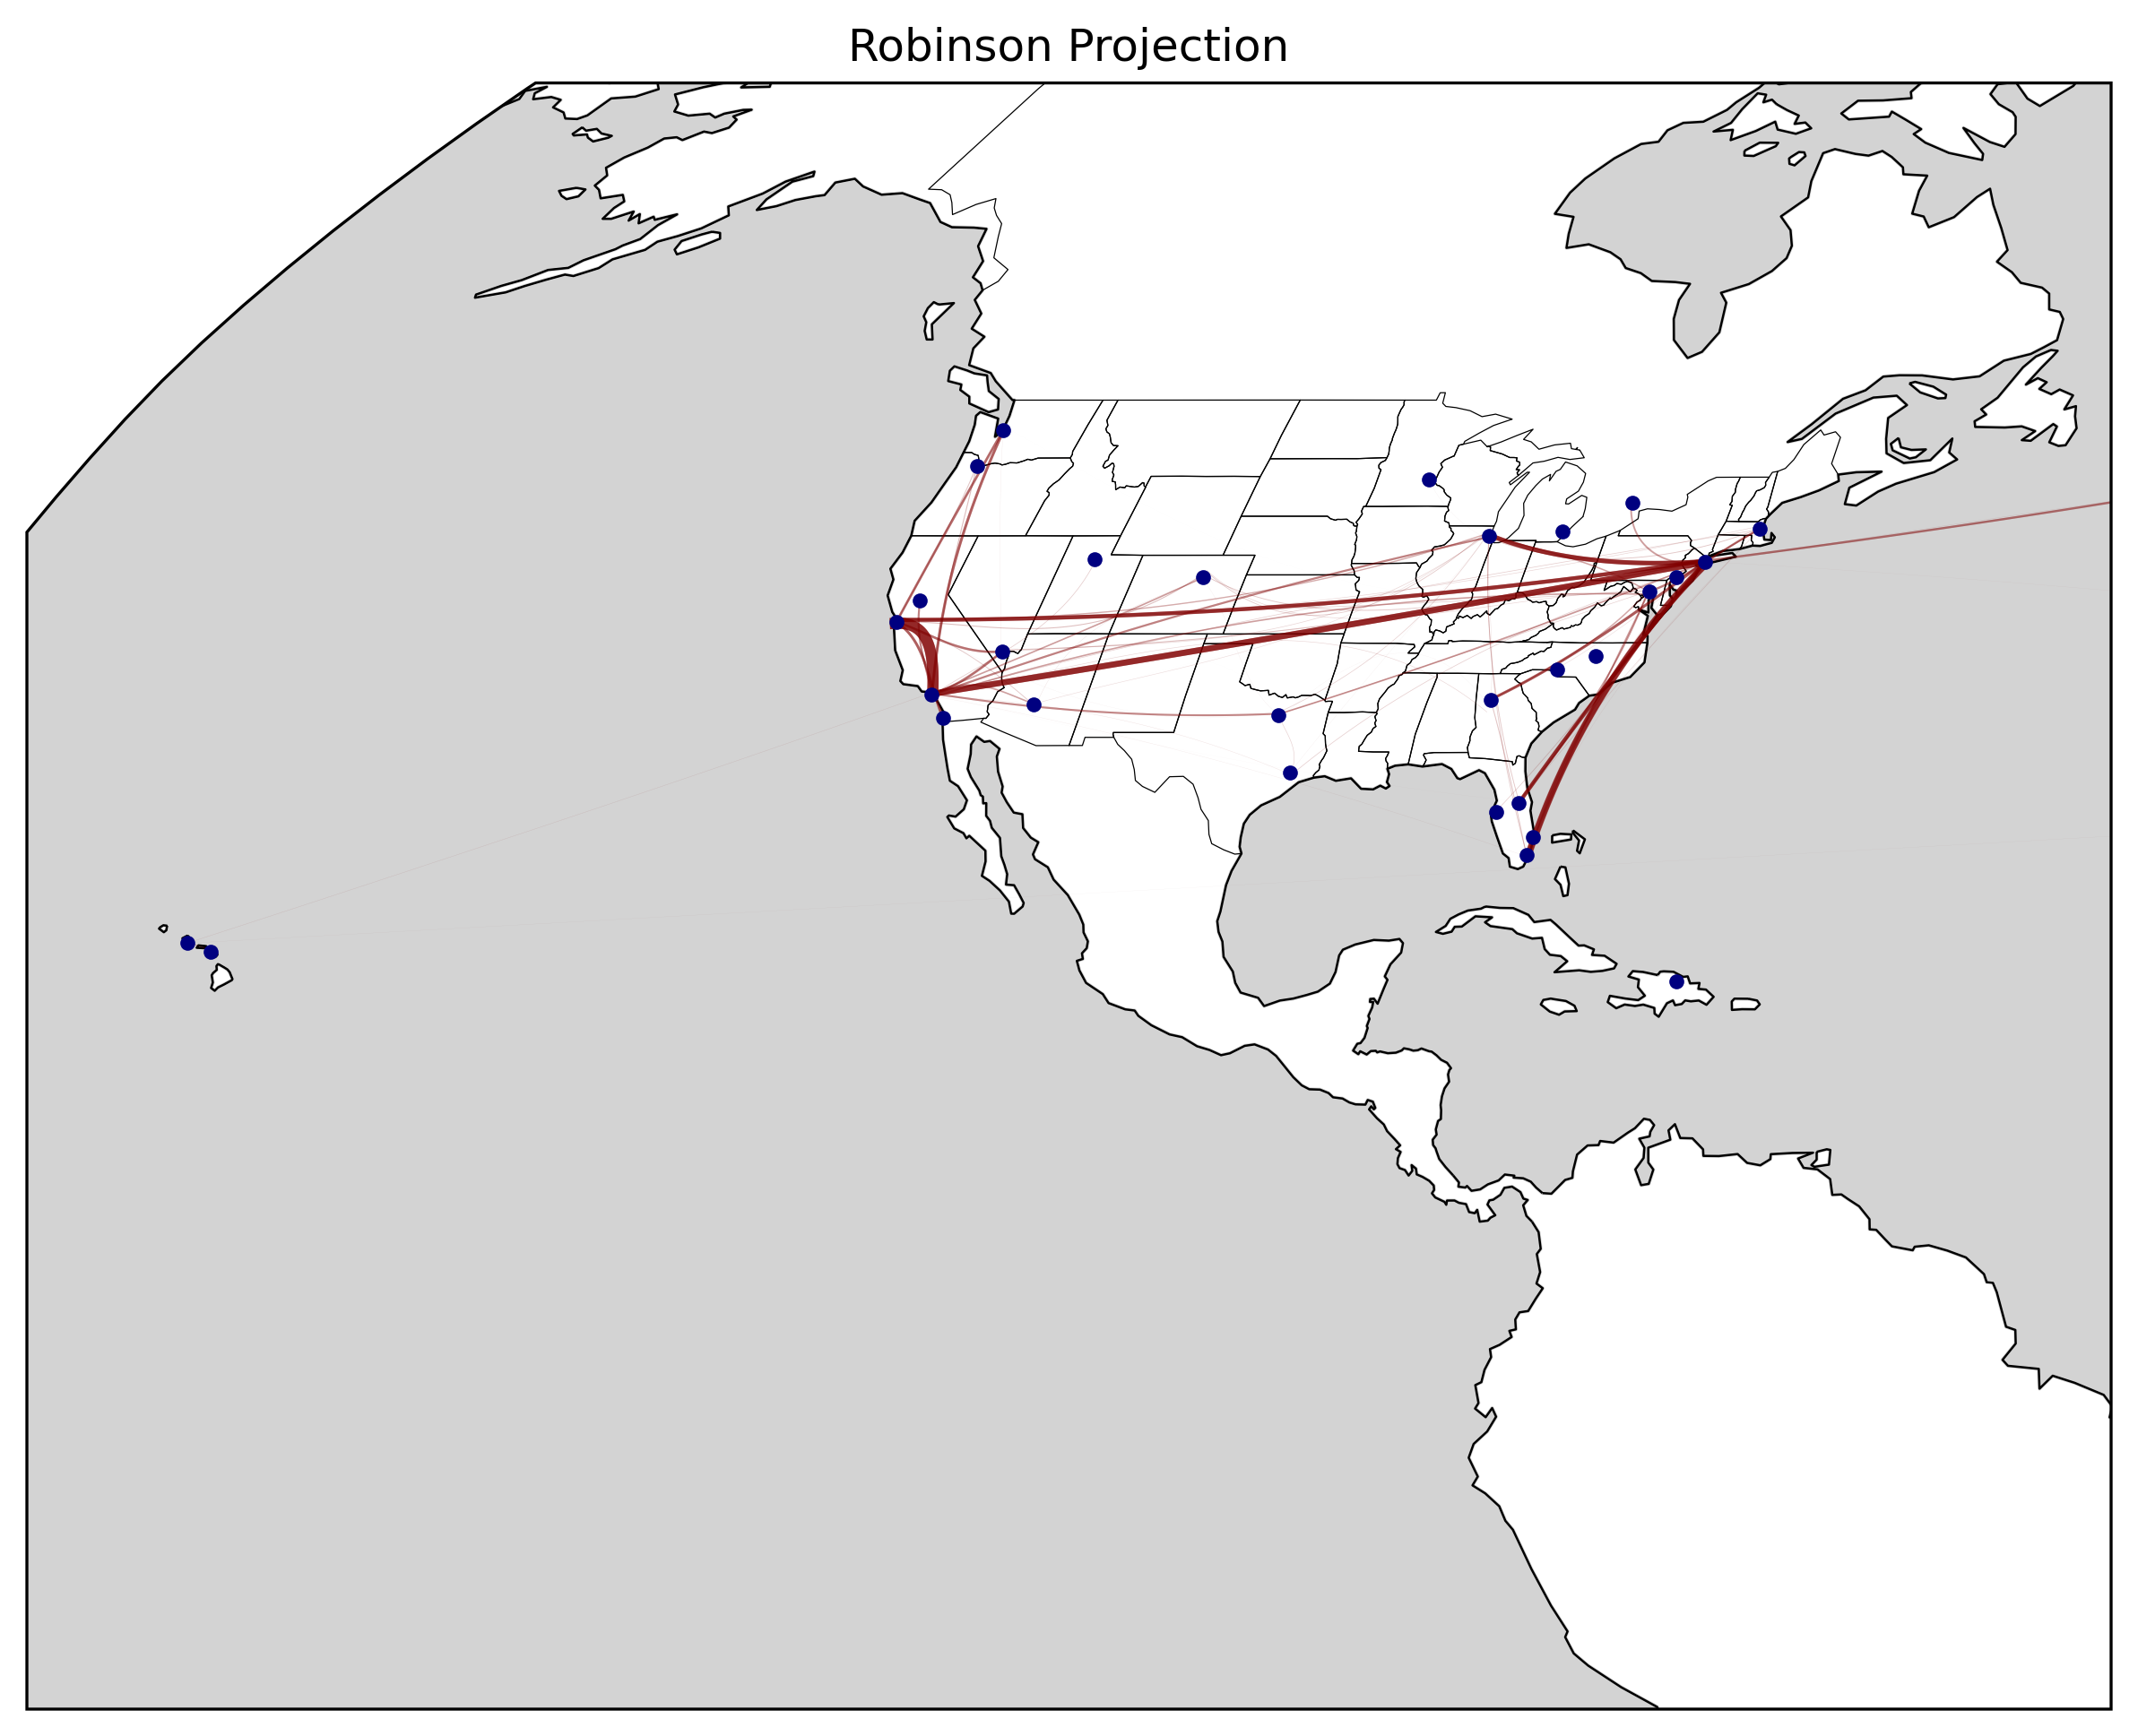

In [29]:
weights = dict(zip(tuple(zip(results['source_basin_label'], results['target_basin_label'])), results['exportations']))
# weights['arbmin'] = 0
norm_weights = normalize_dict_values(weights)

"https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html"
projection = ccrs.Robinson

# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection()}, dpi=300)
ax.set_extent([-164, -52, -10, 52])

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

# ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=1)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')
# ax.add_feature(cartopy.feature.LAKES, color='lightgray')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.6)
ax.add_feature(cartopy.feature.STATES, linestyle='-', linewidth=.3)
# ax.stock_img()

for nodes, path in paths.items():
    ax.plot(path[:, 0], path[:, 1],
            color='maroon',
            linewidth=norm_weights[nodes]*3,
            alpha=max(min((norm_weights[nodes]**1/3)*5, .6), 0),
            transform=ccrs.PlateCarree()
            )
    
    
for node, loc in node_layout.items():
    
    # circular node
    ax.plot(loc[0], loc[1], 
            'o', color='navy', markersize=4,
            markeredgecolor='black', markeredgewidth=0,
            transform=ccrs.PlateCarree())
    
#     # Add text above the node with a box
#     ax.text(loc[0], loc[1] + 0, node, 
#             fontsize=5, fontweight='bold', color = '#4a4a4a',
#             ha='center', va='bottom', 
#             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
#             transform=ccrs.PlateCarree())

plt.title(f'{projection.__name__} Projection')
plt.show()

## Grouping by country/region

In [30]:
q = """
  SELECT 
    g1.country_name as source_country_name,
    AVG(g1.latitude) AS source_lat, 
    AVG(g1.longitude) AS source_lon, 
    g2.country_name AS target_country_name,
    AVG(g2.latitude) AS target_lat, 
    AVG(g2.longitude) AS target_lon, 
    SUM(i.importations) AS exportations
  FROM 
    `net-data-viz-handbook.importation_data.sir_importations_1` AS i
  JOIN 
    `net-data-viz-handbook.reference.gleam-geo-map` AS g1
  ON 
    g1.basin_id = i.source_basin
  JOIN 
    `net-data-viz-handbook.reference.gleam-geo-map` AS g2
  ON 
    g2.basin_id = i.target_basin
  WHERE 
    g1.country_id <> g2.country_id
  GROUP BY 
    g1.country_name,
    g2.country_name
  HAVING
    SUM(i.importations) > 2500
"""

# Run the query
query_job = client.query(q)

# Fetch the results into a pandas DataFrame
results = query_job.result().to_dataframe()

# Display the first few rows
results.head()

C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


source_country_name  source_lat  source_lon       target_country_name  \
0              Mexico   21.141861  -98.079932  United States of America   
1            Portugal   37.280274  -10.274820            United Kingdom   
2              Taiwan   24.495528  121.001601                     China   
3            Portugal   38.998598   -9.431778                    France   
4              Poland   51.687298   19.095650            United Kingdom   

   target_lat  target_lon  exportations  
0   37.136403  -98.035221         22861  
1   52.990350   -2.080701          6859  
2   30.494483  115.313310         24846  
3   46.359530    3.333493          6700  
4   53.077732   -1.961578          9312

In [31]:
q = f"""
WITH basins AS (
    SELECT 
        i.source_basin AS basin,
        SUM(i.importations) AS importations,
        g.latitude AS lat, 
        g.longitude AS lon,
        g.country_name
    FROM 
        `net-data-viz-handbook.importation_data.sir_importations_1` AS i
    JOIN 
        `net-data-viz-handbook.reference.gleam-geo-map` AS g
    ON 
        i.source_basin = g.basin_id
    GROUP BY
        i.source_basin,
        g.latitude,
        g.longitude,
        g.country_name
),
weighted_avg AS (
    SELECT 
        country_name,
        AVG(lat) AS lat,
        AVG(lon) AS lon
    FROM 
        basins
    GROUP BY 
        country_name
)
SELECT *
FROM weighted_avg;
"""

# Run the query
query_job = client.query(q)

# Fetch the results into a pandas DataFrame
all_countries = query_job.result().to_dataframe()

# Create the node_layout dictionary
node_layout = dict(zip(all_countries['country_name'], np.array(list(zip(all_countries['lon'], all_countries['lat'])))))

# Check the result
node_layout

C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


{'Mexico': array([-100.9353431 ,   22.20165862]),
 'Korea, Rep.': array([127.59895   ,  35.80811667]),
 'Canada': array([-91.78871421,  55.16423224]),
 'Colombia': array([-74.83504318,   5.36291136]),
 'Portugal': array([-16.85366923,  38.11242308]),
 'Taiwan': array([120.42761429,  23.81921429]),
 'Brazil': array([-49.96365327, -15.43387944]),
 'Cuba': array([-78.30807059,  21.42075882]),
 'Poland': array([18.9998    , 51.85126364]),
 'Peru': array([-75.552835,  -9.996455]),
 'United States of America': array([-106.20333385,   42.86443824]),
 'India': array([79.63966197, 21.69488169]),
 'France': array([ 2.52933043, 45.81345217]),
 'Spain': array([-5.42099474, 37.78135   ]),
 'Ireland': array([-8.20804286, 53.04102857]),
 'Switzerland': array([ 8.12534, 46.82124]),
 'Vietnam': array([106.891695,  14.196755]),
 'Norway': array([14.61310286, 65.40362286]),
 'Thailand': array([100.77522258,  13.95422258]),
 'Japan': array([136.08703898,  36.05459831]),
 'Malta': array([14.4775, 35.8575])

In [32]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for idx, row in results.iterrows():
    G.add_edge(row['source_country_name'], row['target_country_name'], weight=row['exportations'])

scaled_pos = {basin: np.array((coords[0]/180, coords[1]/180)) for basin, coords in node_layout.items()}

edges = list(G.edges)

In [33]:
"https://netgraph.readthedocs.io/en/latest/edge_layout.html#netgraph.get_bundled_edge_paths"

# Initialize paths using original node positions and edges
""" I like these settings for global maps; they seem to do the job well enough at all scales """
paths = netgraph.get_bundled_edge_paths(edges=edges, 
                                        node_positions=scaled_pos, 
                             compatibility_threshold=0.02,
#                                 straighten_by=0.01,
                                        step_size=.0002,
                                       k=1000,
                                       total_cycles=7)

# Scale paths if needed
for key, value in paths.items():
    paths[key] = value * 180

paths;

C:\Users\elija\anaconda3\Lib\site-packages\netgraph\_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


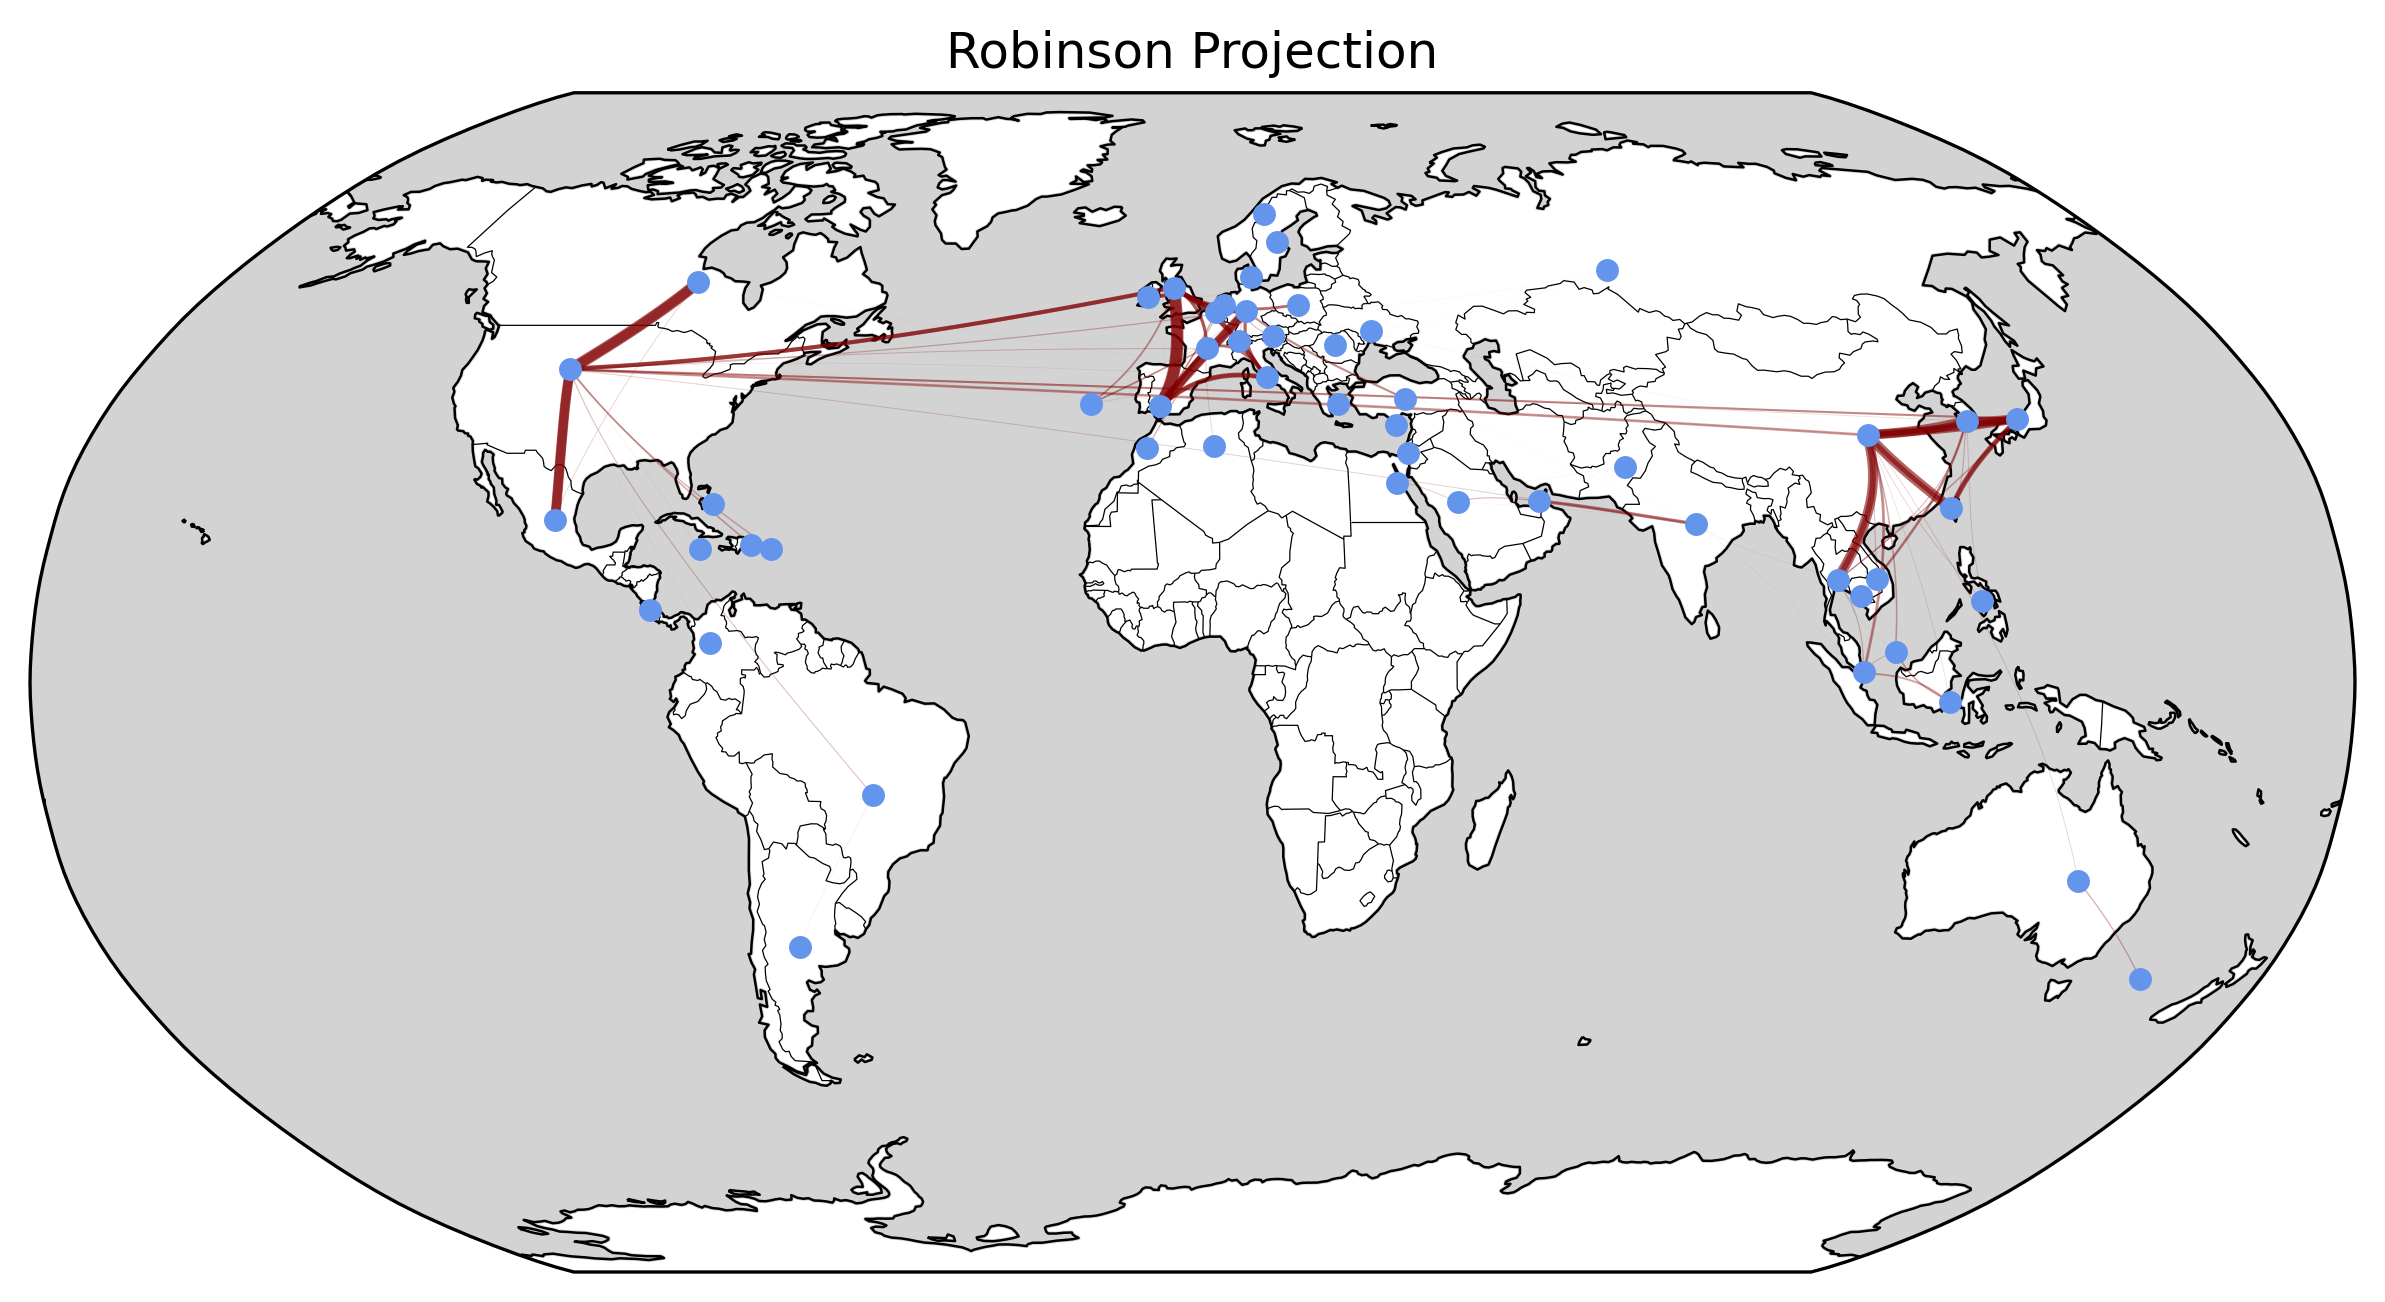

In [34]:
# getting countries that appear in path
appear = {country for key in paths.keys() for country in key}

weights = dict(zip(tuple(zip(results['source_country_name'], results['target_country_name'])), results['exportations']))
# weights['arbmin'] = 0
norm_weights = normalize_dict_values(weights)

"https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html"
projection = ccrs.Robinson

# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection()}, dpi=300)
ax.set_extent([-180, 180, -90, 90])

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.3)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')
# ax.add_feature(cartopy.feature.LAKES, color='lightgray')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.6)
# ax.add_feature(cartopy.feature.STATES, linestyle='-', linewidth=.3)
# ax.stock_img()

for nodes, path in paths.items():
    ax.plot(path[:, 0], path[:, 1],
            color='maroon',
            linewidth=norm_weights[nodes]*3,
            alpha=max(min((norm_weights[nodes]**1/3)*5, .6), 0),
            transform=ccrs.PlateCarree(),
            solid_capstyle='round',

            )
    
    
for node, loc in node_layout.items():
    
    # circular node
    if node in appear: 
        ax.plot(loc[0], loc[1], 
                'o', color='cornflowerblue', markersize=5.5,
                markeredgecolor='black', markeredgewidth=0,
                transform=ccrs.PlateCarree())
    
#     # Add text above the node with a box
#     if node in appear:
#         ax.text(loc[0], loc[1] + 0, node, 
#                 fontsize=5, fontweight='bold', color = '#4a4a4a',
#                 ha='center', va='bottom', 
#                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
#                 transform=ccrs.PlateCarree())

plt.title(f'{projection.__name__} Projection')
plt.show()

C:\Users\elija\AppData\Local\Temp\ipykernel_12384\2089108961.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', pad=0.05, aspect=40, shrink=0.7)


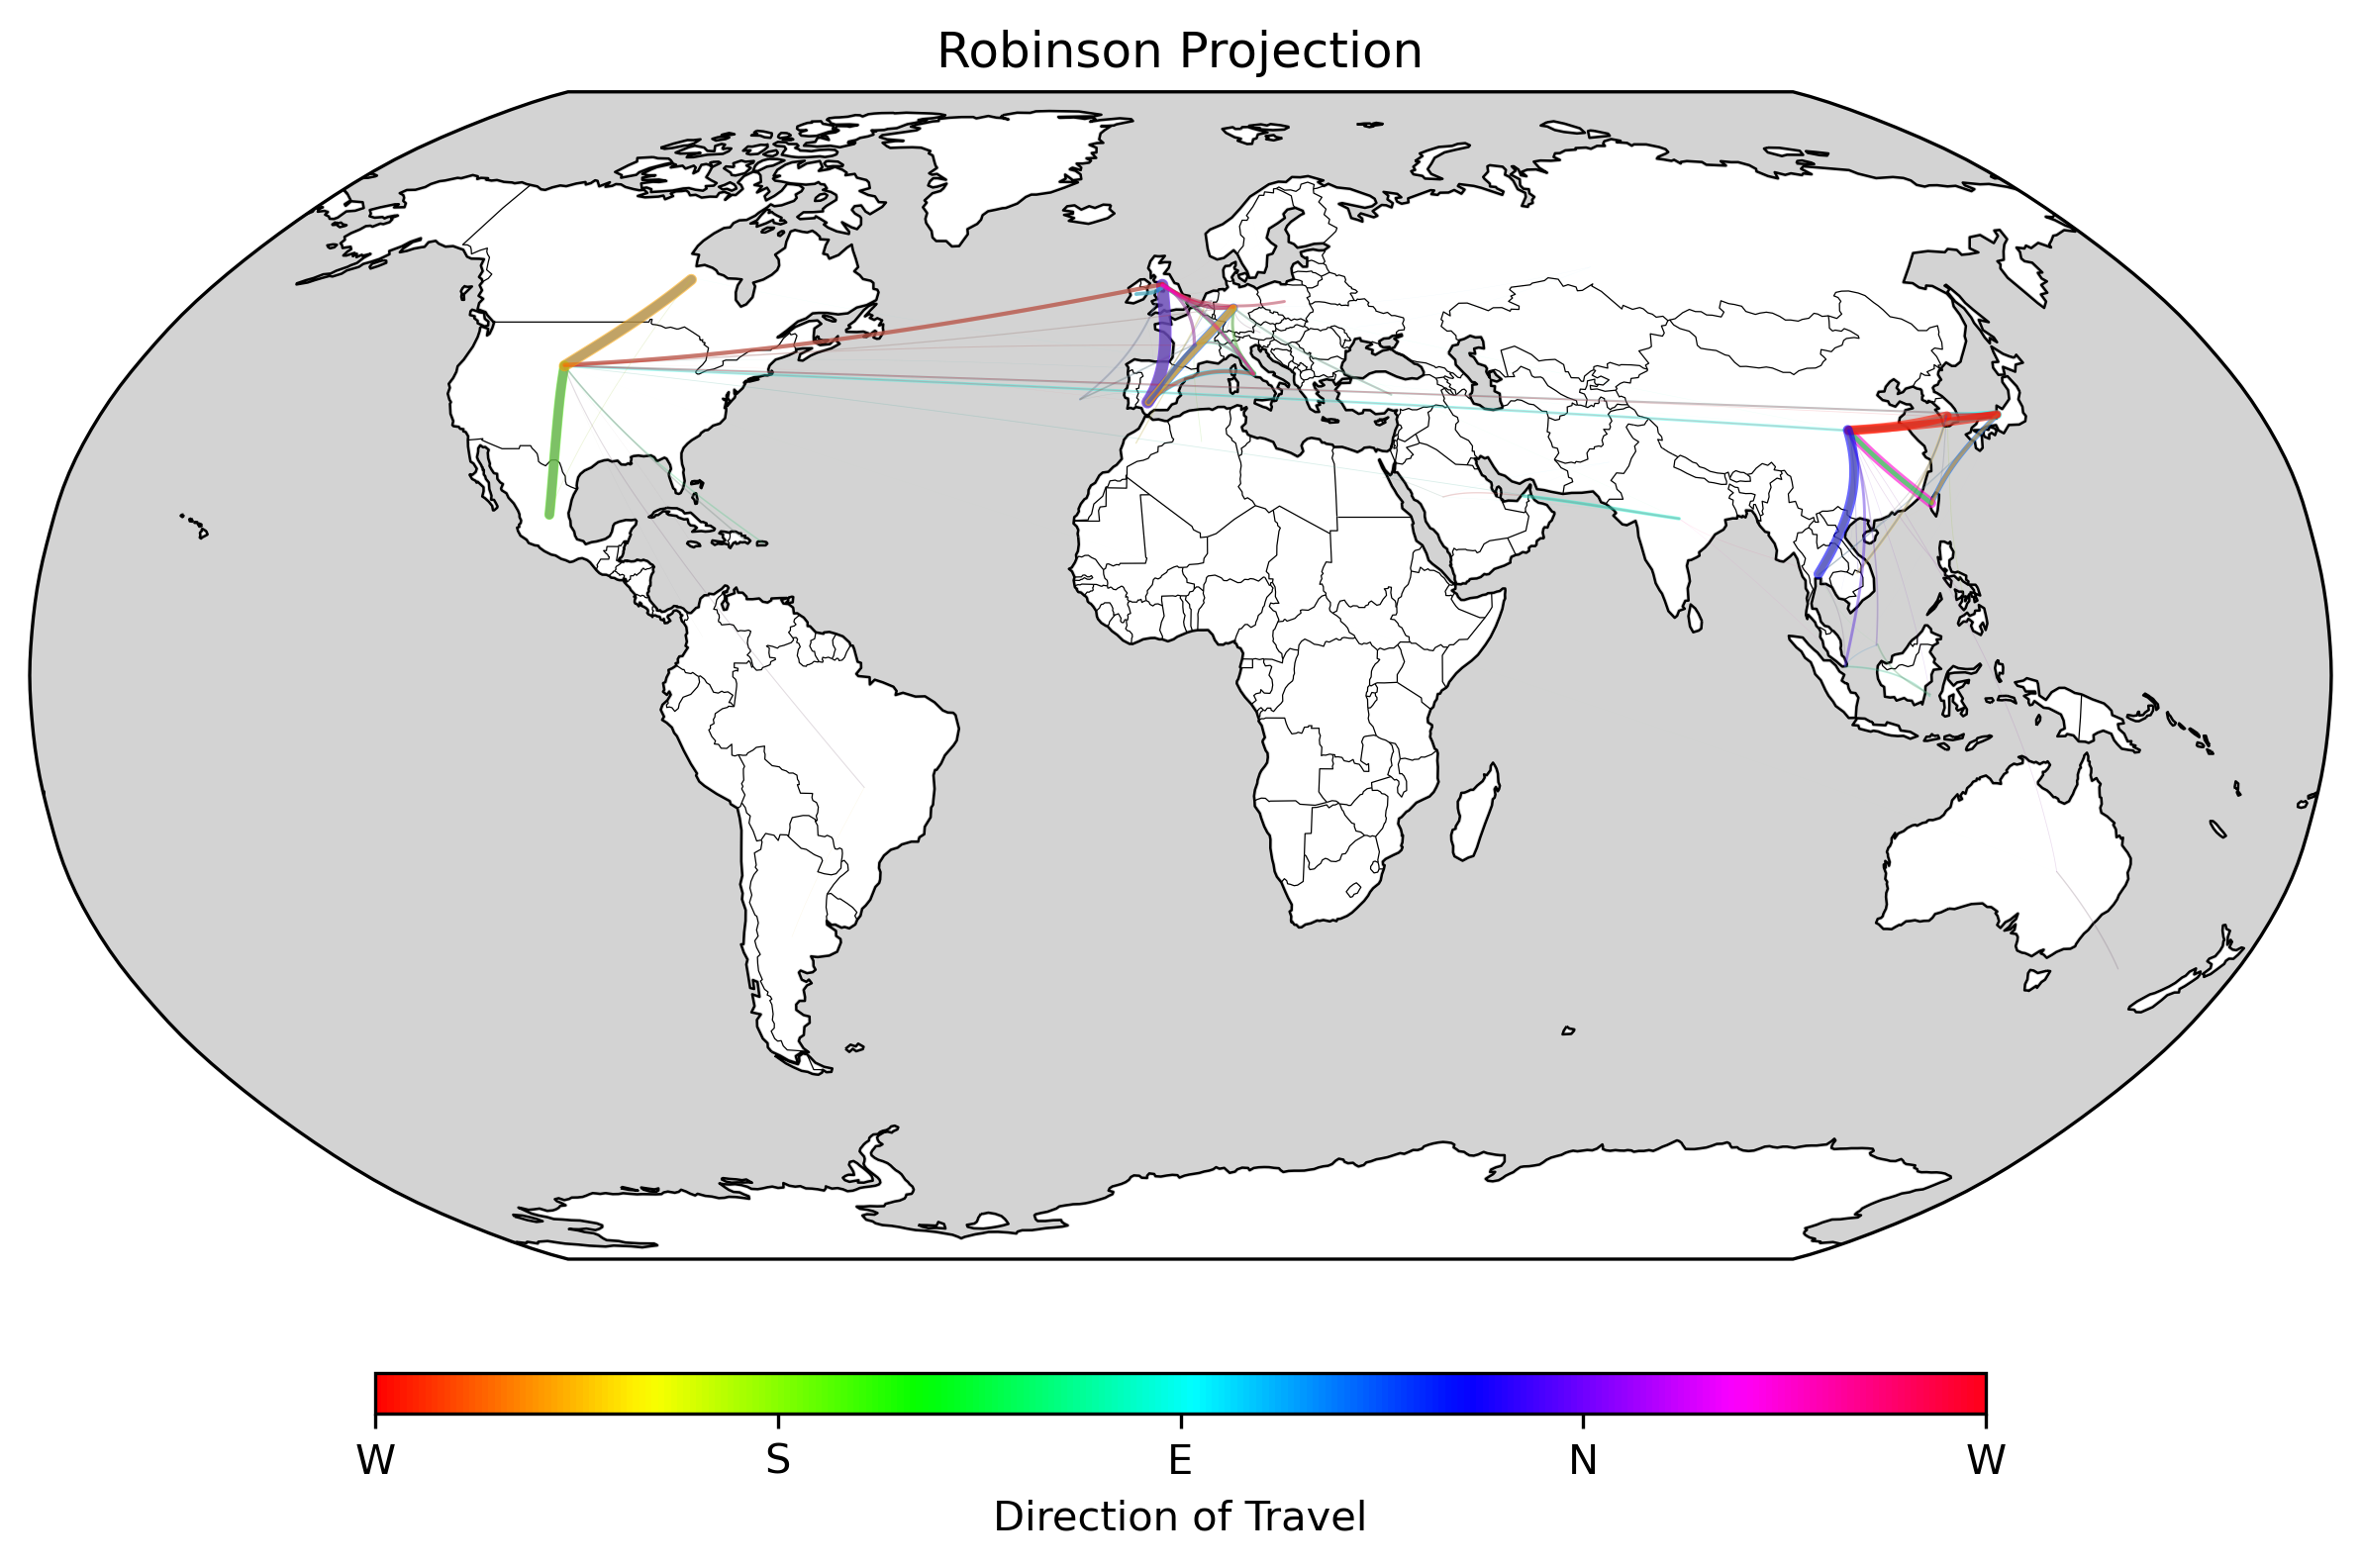

In [35]:
from matplotlib.colors import Normalize

appear = {country for key in paths.keys() for country in key}
norm_weights = normalize_dict_values(weights)
projection = ccrs.Robinson

# Set up the figure with Cartopy projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection()}, dpi=300)
ax.set_extent([-180, 180, -90, 90])

# Add map features
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.3)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.6)

# Set up HSV colormap
cmap = cm.hsv
norm = Normalize(vmin=-np.pi, vmax=np.pi)  # Normalize between -π and π for direction angles

# Plot each path with color based on direction
for nodes, path in paths.items():
    # Calculate direction in radians
    dy, dx = path[-1, 1] - path[0, 1], path[-1, 0] - path[0, 0]
    angle = np.arctan2(dy, dx)  # Direction angle in radians

    # Use HSV colormap based on angle
    color = cmap(norm(angle))

    ax.plot(path[:, 0], path[:, 1],
            color=color,
            linewidth=norm_weights[nodes] * 3,
            alpha=max(min((norm_weights[nodes] ** 1/3) * 5, .6), 0),
            transform=ccrs.PlateCarree(),
            solid_capstyle='round')

# Plot nodes
# for node, loc in node_layout.items():
#     if node in appear:
#         ax.plot(loc[0], loc[1], 
#                 'o', color='cornflowerblue', markersize=5.5,
#                 markeredgecolor='black', markeredgewidth=0,
#                 transform=ccrs.PlateCarree())

# Add colorbar with cardinal directions
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.05, aspect=40, shrink=0.7)
cbar.set_ticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
cbar.set_ticklabels(['W', 'S', 'E', 'N', 'W'])
cbar.set_label('Direction of Travel')

plt.title(f'{projection.__name__} Projection')
plt.show()

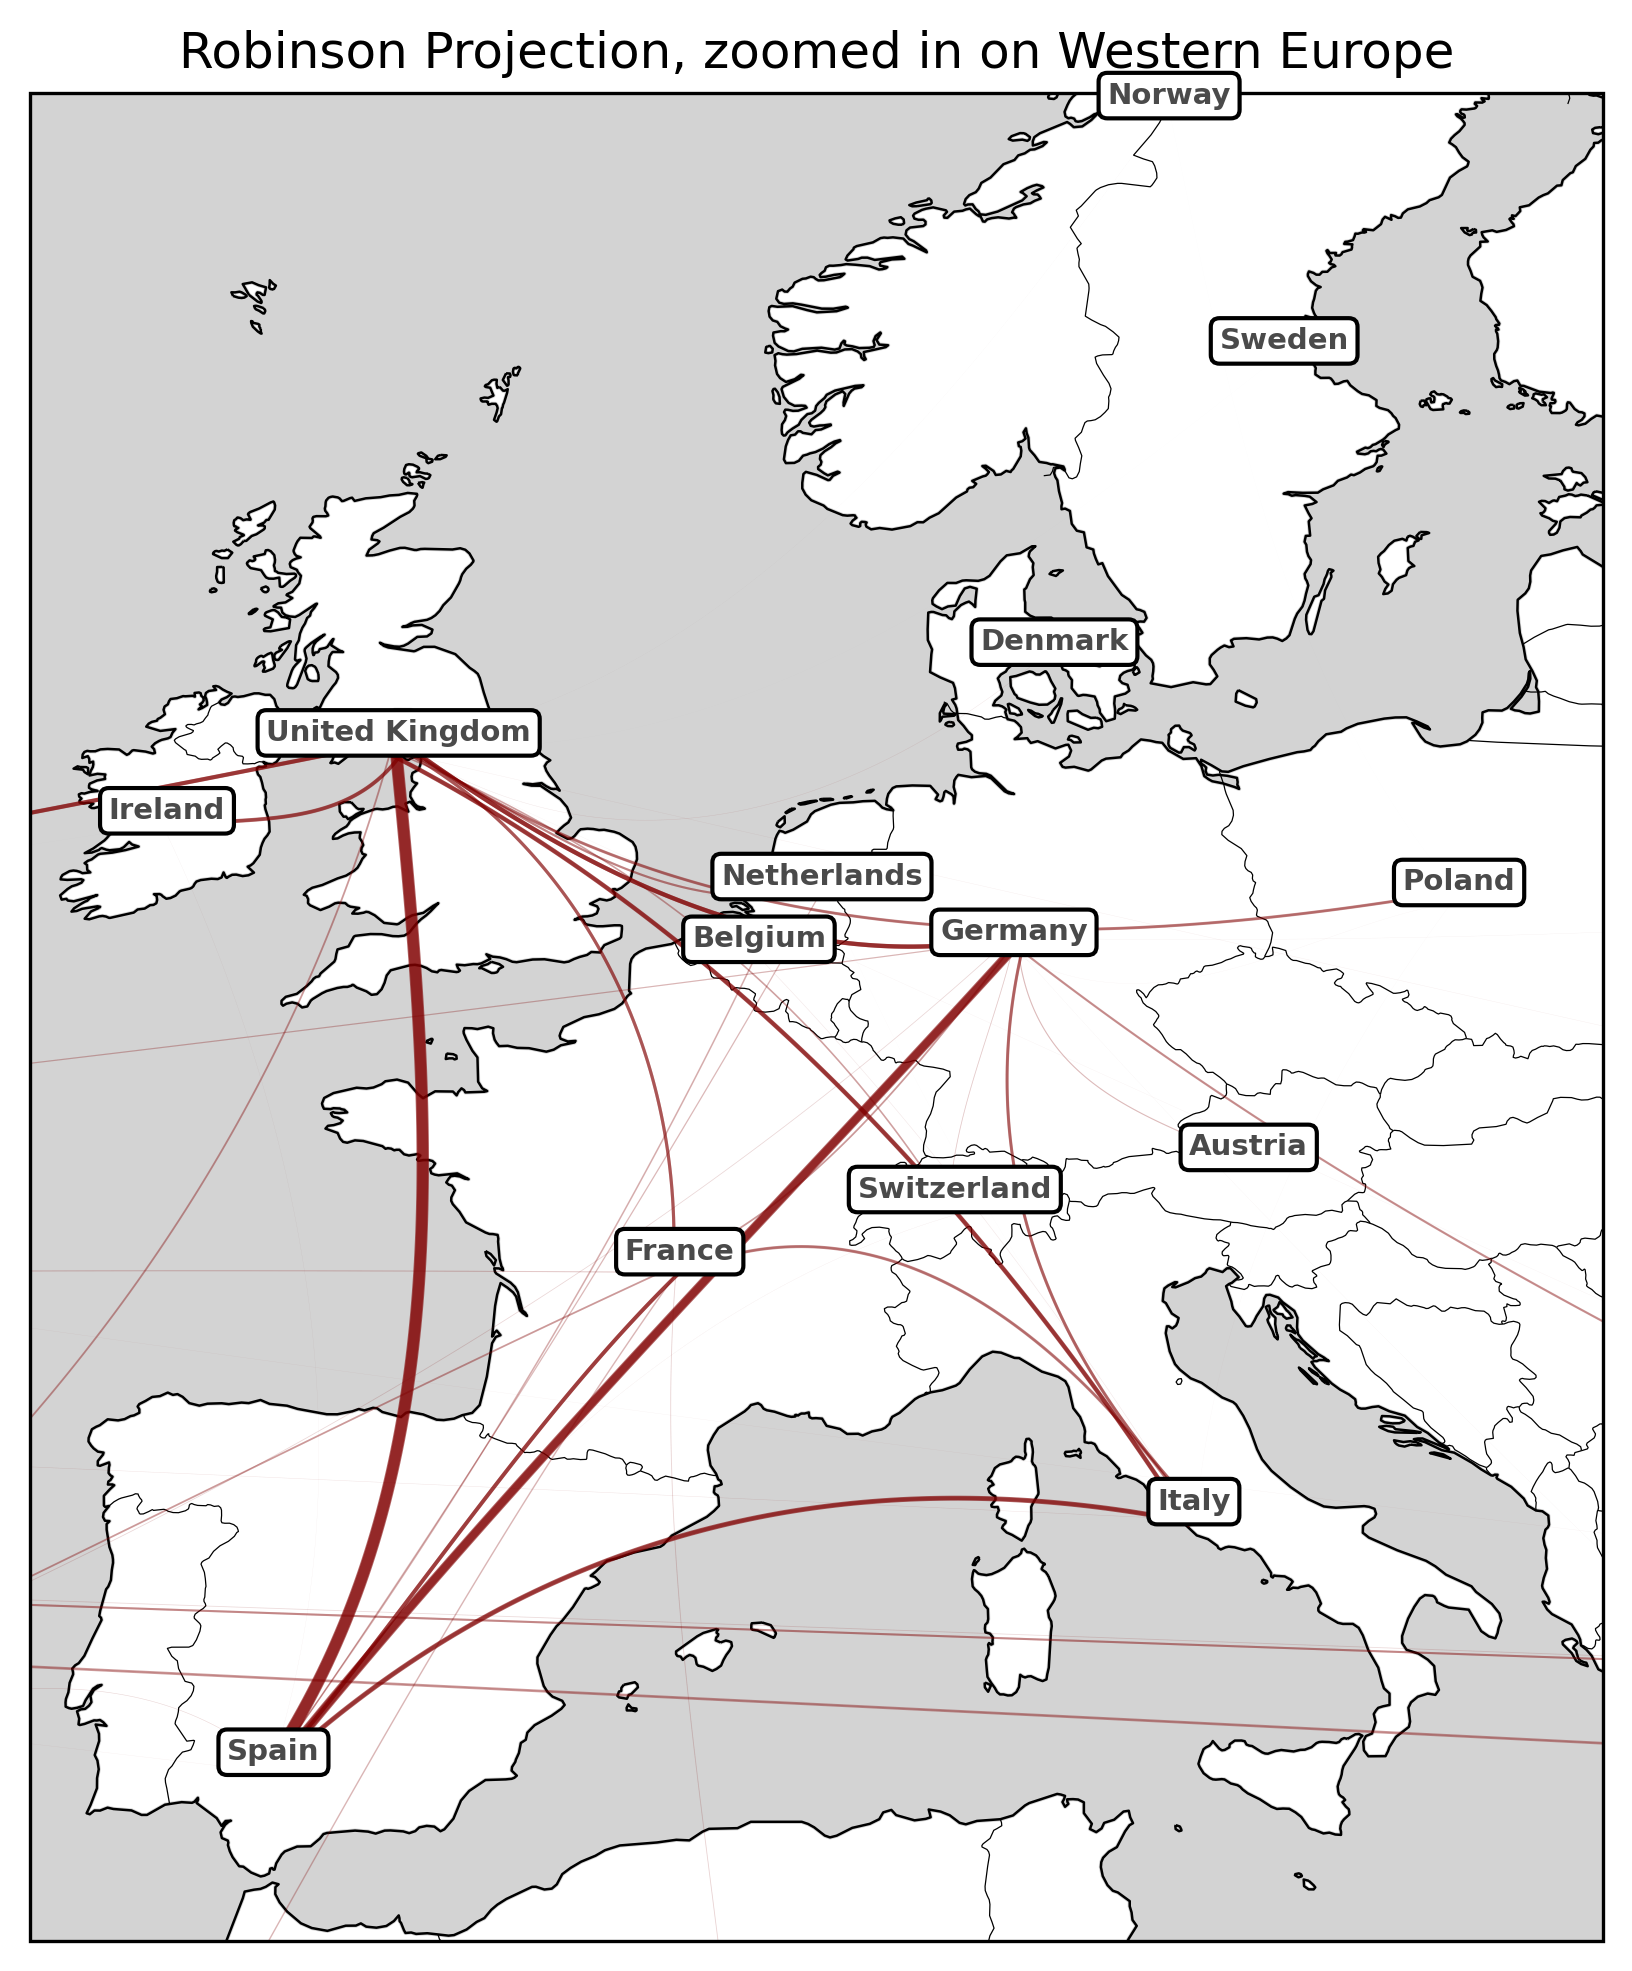

In [36]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection()}, dpi=300)
ax.set_extent([-10, 20, 35, 65])

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.3)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')
# ax.add_feature(cartopy.feature.LAKES, color='lightgray')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.6)
# ax.add_feature(cartopy.feature.STATES, linestyle='-', linewidth=.3)
# ax.stock_img()

for nodes, path in paths.items():
    ax.plot(path[:, 0], path[:, 1],
            color='maroon',
            linewidth=norm_weights[nodes]*3,
            alpha=max(min((norm_weights[nodes]**1/3)*5, .6), 0),
            transform=ccrs.PlateCarree()
            )
    

# Get the x and y limits in the projection's native coordinate system
xlim, ylim = ax.get_xlim(), ax.get_ylim()

for node, loc in node_layout.items():
    lon, lat = loc[0], loc[1]
    
    # Transform the node's (lon, lat) from PlateCarree to the map projection's coordinate system
    projected = ax.projection.transform_points(ccrs.PlateCarree(), np.array([lon]), np.array([lat]))
    
    # projected is an array where [:,0] is the x-coordinate and [:,1] is the y-coordinate in the map's native projection
    x, y = projected[0, 0], projected[0, 1]
    
#     # Check if the projected coordinates are within the x and y limits of the plot
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1] and node in appear:
        # Add text above the node with a box if within the visible area
        ax.text(lon, lat + 0, node, 
                fontsize=7, fontweight='bold', color='#4a4a4a',
                ha='center', va='bottom', 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
                transform=ccrs.PlateCarree())

    
#     if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1] and node in appear:
#         # circular node
#         ax.plot(loc[0], loc[1], 
#                 'o', color='navy', markersize=10,
#                 markeredgecolor='black', markeredgewidth=0,
#                 transform=ccrs.PlateCarree())

plt.title(f'{projection.__name__} Projection, zoomed in on Western Europe')
plt.show()

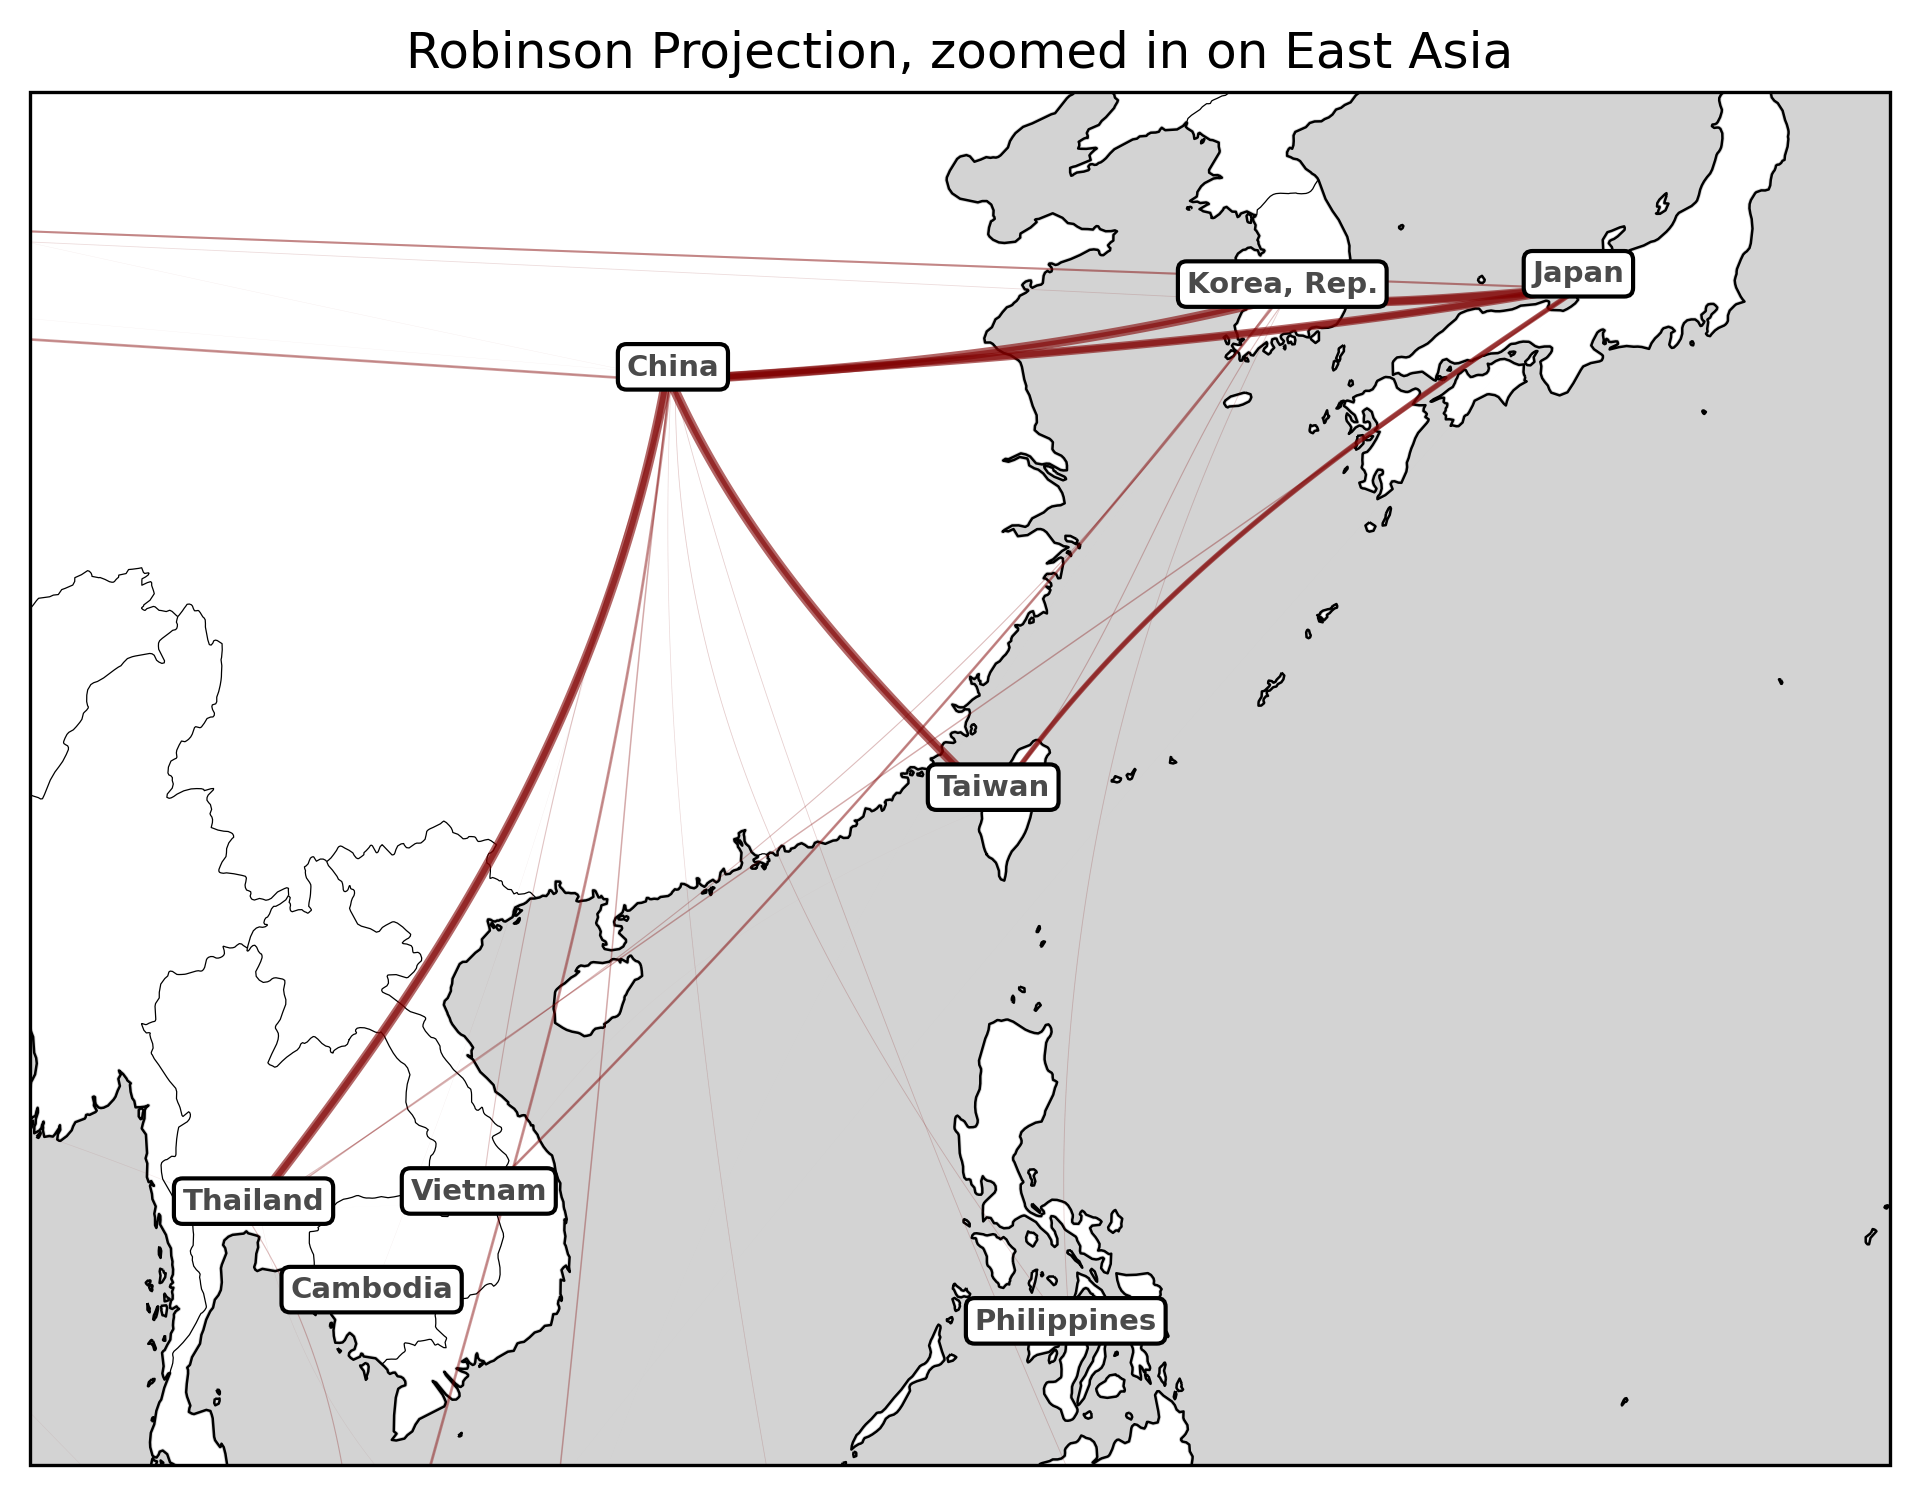

In [37]:
# Create a map using Cartopy
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection(central_longitude=150)}, dpi=300)
ax.set_extent([95, 145, 8, 38])

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.3)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')
# ax.add_feature(cartopy.feature.LAKES, color='lightgray')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.6)
# ax.add_feature(cartopy.feature.STATES, linestyle='-', linewidth=.3)
# ax.stock_img()

for nodes, path in paths.items():
    ax.plot(path[:, 0], path[:, 1],
            color='maroon',
            linewidth=norm_weights[nodes]*3,
            alpha=max(min((norm_weights[nodes]**1/3)*5, .6), 0),
            transform=ccrs.PlateCarree()
            )
    

# Get the x and y limits in the projection's native coordinate system
xlim, ylim = ax.get_xlim(), ax.get_ylim()

for node, loc in node_layout.items():
    lon, lat = loc[0], loc[1]
    
    # Transform the node's (lon, lat) from PlateCarree to the map projection's coordinate system
    projected = ax.projection.transform_points(ccrs.PlateCarree(), np.array([lon]), np.array([lat]))
    
    # projected is an array where [:,0] is the x-coordinate and [:,1] is the y-coordinate in the map's native projection
    x, y = projected[0, 0], projected[0, 1]
    
#     # Check if the projected coordinates are within the x and y limits of the plot
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1] and node in appear:
        # Add text above the node with a box if within the visible area
        ax.text(lon, lat + 0, node, 
                fontsize=7, fontweight='bold', color='#4a4a4a',
                ha='center', va='bottom', 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
                transform=ccrs.PlateCarree())

    
#     if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1] and node in appear:
#         # circular node
#         ax.plot(loc[0], loc[1], 
#                 'o', color='navy', markersize=10,
#                 markeredgecolor='black', markeredgewidth=0,
#                 transform=ccrs.PlateCarree())

plt.title(f'{projection.__name__} Projection, zoomed in on East Asia')
plt.show()